In [1]:
!python --version

Python 3.9.0


In [2]:
!export TF_GPU_ALLOCATOR=cuda_malloc_async

In [3]:
import tensorflow as tf
tf.__version__

'2.8.0'

In [4]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  1


In [5]:
# Creates a session with device placement logs
sess = tf.compat.v1.Session(config=tf.compat.v1.ConfigProto(log_device_placement=True))
print(sess)

Device mapping:
/job:localhost/replica:0/task:0/device:GPU:0 -> device: 0, name: NVIDIA GeForce GTX 1060 6GB, pci bus id: 0000:01:00.0, compute capability: 6.1



In [1]:
# GPU for training.
DEVICE = "/gpu:0"  # /cpu:0 or /gpu:0

In [1]:
import warnings
warnings.filterwarnings('ignore')
import os
import sys
import json
import datetime
import numpy as np
import skimage.draw
import cv2
import random
import math
import re
import time
import tensorflow as tf
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import matplotlib.image as mpimg

from mrcnn import utils
from mrcnn import visualize
from mrcnn.visualize import display_images
from mrcnn.visualize import display_instances
import mrcnn.model as modellib
from mrcnn.model import log
from mrcnn.config import Config
from mrcnn import model as modellib, utils

# Root directory of the project
#ROOT_DIR = "D:\MRCNN_tensorflow2.7_env\Mask-RCNN"
ROOT_DIR = os.getcwd()

# Import Mask RCNN
sys.path.append(ROOT_DIR)  # To find local version of the library


# Path to trained weights file
COCO_WEIGHTS_PATH = os.path.join(ROOT_DIR, "mask_rcnn_coco.h5")

# Directory to save logs and model checkpoints, if not provided
# through the command line argument --logs
DEFAULT_LOGS_DIR = os.path.join(ROOT_DIR, "logs")


In [2]:

class CustomConfig(Config):
    """Configuration for training on the custom  dataset.
    Derives from the base Config class and overrides some values.
    """
    # Give the configuration a recognizable name
    NAME = "object"


    # NUMBER OF GPUs to use. When using only a CPU, this needs to be set to 1.
    GPU_COUNT = 1
    
    # We use a GPU with 12GB memory, which can fit two images.
    # Adjust down if you use a smaller GPU.
    IMAGES_PER_GPU = 1
    
    # Number of classes (including background)
    NUM_CLASSES = 1 + 1  # Background + speedbump

    # Number of training steps per epoch
    STEPS_PER_EPOCH = 5

    # Skip detections with < 90% confidence
    DETECTION_MIN_CONFIDENCE = 0.9


In [3]:
class InferenceConfig(CustomConfig):
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1
    #Minimum probability value to accept a detected instance
    # ROIs below this threshold are skipped
    DETECTION_MIN_CONFIDENCE = 0.7

    # Non-maximum suppression threshold for detection
    DETECTION_NMS_THRESHOLD = 0.3

inference_config = InferenceConfig()

# Recreate the model in inference mode
model = modellib.MaskRCNN(mode="inference", 
                          config=inference_config,
                          model_dir=DEFAULT_LOGS_DIR)

# Get path to saved weights
# Either set a specific path or find last trained weights
# model_path = os.path.join(ROOT_DIR, ".h5 file name here")


#model_path = model.find_last()
model_path = '/home/brin/Rahma/SpeedBumpDetection/logs/object20240206T1432/mask_rcnn_object_0100.h5'


# Load trained weights
print("Loading weights from ", model_path)
model.load_weights(model_path, by_name=True)




Instructions for updating:
Use fn_output_signature instead
Loading weights from  /home/brin/Rahma/SpeedBumpDetection/logs/object20240206T1432/mask_rcnn_object_0100.h5
Re-starting from epoch 100


In [4]:
class CustomDataset(utils.Dataset):

    def load_custom(self, dataset_dir, subset):
        """Load a subset of the Dog-Cat dataset.
        dataset_dir: Root directory of the dataset.
        subset: Subset to load: train or val
        """
        # Add classes. We have only one class to add.
      
        # Add classes. We have only one class to add.
        self.add_class("object", 1, "speedbump")


     
        # Train or validation dataset?
        assert subset in ["train", "val"]
        dataset_dir = os.path.join(dataset_dir, subset)

        # We mostly care about the x and y coordinates of each region
        annotations1 = json.load(open('/home/brin/Rahma/SpeedBumpDetection/data/train/train.json'))
        # print(annotations1)
        annotations = list(annotations1.values())  # don't need the dict keys

        # The VIA tool saves images in the JSON even if they don't have any
        # annotations. Skip unannotated images.
        annotations = [a for a in annotations if a['regions']]
        
        # Add images
        for a in annotations:
            # print(a)
            # Get the x, y coordinaets of points of the polygons that make up
            # the outline of each object instance. There are stores in the
            # shape_attributes (see json format above)
            polygons = [r['shape_attributes'] for r in a['regions']] 
            objects = [s['region_attributes']['names'] for s in a['regions']]
            print("objects:",objects)
            name_dict = {"speedbump": 1}

            # key = tuple(name_dict)
            num_ids = [name_dict[a] for a in objects]
     

            print("numids",num_ids)
            image_path = os.path.join(dataset_dir, a['filename'])
            image = skimage.io.imread(image_path)
            height, width = image.shape[:2]

            self.add_image(
                "object",  ## for a single class just add the name here
                image_id=a['filename'],  # use file name as a unique image id
                path=image_path,
                width=width, height=height,
                polygons=polygons,
                num_ids=num_ids
                )

    def load_mask(self, image_id):
        """Generate instance masks for an image.
       Returns:
        masks: A bool array of shape [height, width, instance count] with
            one mask per instance.
        class_ids: a 1D array of class IDs of the instance masks.
        """
        # If not a Dog-Cat dataset image, delegate to parent class.
        image_info = self.image_info[image_id]
        if image_info["source"] != "object":
            return super(self.__class__, self).load_mask(image_id)

        # Convert polygons to a bitmap mask of shape
        # [height, width, instance_count]
        info = self.image_info[image_id]
        if info["source"] != "object":
            return super(self.__class__, self).load_mask(image_id)
        num_ids = info['num_ids']
        mask = np.zeros([info["height"], info["width"], len(info["polygons"])],
                        dtype=np.uint8)
        for i, p in enumerate(info["polygons"]):
            # Get indexes of pixels inside the polygon and set them to 1
        	rr, cc = skimage.draw.polygon(p['all_points_y'], p['all_points_x'])

        	mask[rr, cc, i] = 1

        # Return mask, and array of class IDs of each instance. Since we have
        # one class ID only, we return an array of 1s
        # Map class names to class IDs.
        num_ids = np.array(num_ids, dtype=np.int32)
        return mask, num_ids #np.ones([mask.shape[-1]], dtype=np.int32)

    def image_reference(self, image_id):
        """Return the path of the image."""
        info = self.image_info[image_id]
        if info["source"] == "object":
            return info["path"]
        else:
            super(self.__class__, self).image_reference(image_id)

In [5]:
# Training dataset.
dataset_train = CustomDataset()
dataset_train.load_custom("/home/brin/Rahma/SpeedBumpDetection/data", "train")
dataset_train.prepare()

# Validation dataset
dataset_val = CustomDataset()
dataset_val.load_custom("/home/brin/Rahma/SpeedBumpDetection/data", "val")
dataset_val.prepare()

objects: ['speedbump']
numids [1]
objects: ['speedbump']
numids [1]
objects: ['speedbump']
numids [1]
objects: ['speedbump']
numids [1]
objects: ['speedbump', 'speedbump']
numids [1, 1]
objects: ['speedbump']
numids [1]
objects: ['speedbump']
numids [1]
objects: ['speedbump']
numids [1]
objects: ['speedbump']
numids [1]
objects: ['speedbump']
numids [1]
objects: ['speedbump']
numids [1]
objects: ['speedbump']
numids [1]
objects: ['speedbump', 'speedbump']
numids [1, 1]
objects: ['speedbump']
numids [1]
objects: ['speedbump']
numids [1]
objects: ['speedbump']
numids [1]


original_image           shape: (512, 512, 3)         min:    0.00000  max:  255.00000  uint8
image_meta               shape: (14,)                 min:    0.00000  max: 1280.00000  float64
gt_class_id              shape: (1,)                  min:    1.00000  max:    1.00000  int32
gt_bbox                  shape: (1, 4)                min:   63.00000  max:  467.00000  int32
gt_mask                  shape: (512, 512, 1)         min:    0.00000  max:    1.00000  uint8


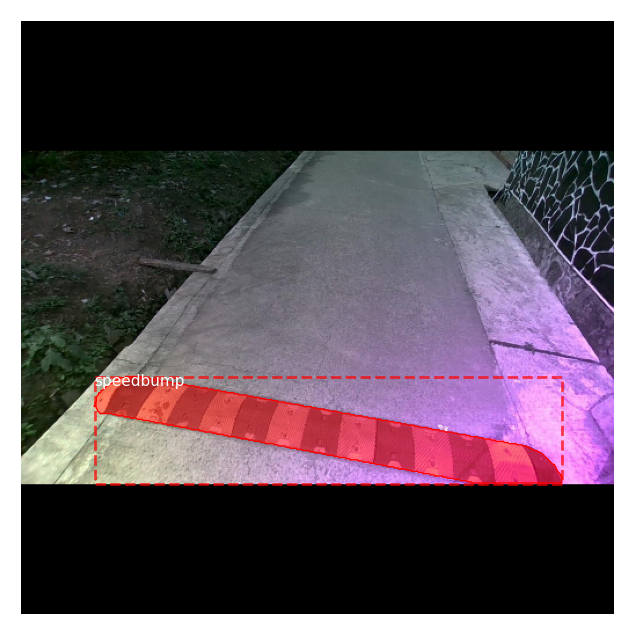

In [6]:
# Test on a random image
image_id = random.choice(dataset_val.image_ids)
original_image, image_meta, gt_class_id, gt_bbox, gt_mask =\
    modellib.load_image_gt(dataset_val, inference_config, 
                           image_id)

log("original_image", original_image)
log("image_meta", image_meta)
log("gt_class_id", gt_class_id)
log("gt_bbox", gt_bbox)
log("gt_mask", gt_mask)

visualize.display_instances(original_image, gt_bbox, gt_mask, gt_class_id, 
                            dataset_train.class_names, figsize=(8, 8))

# Testing on all unseen images at once

Processing 1 images
image                    shape: (720, 1280, 3)        min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max: 1280.00000  float64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32


2024-02-06 14:47:13.178493: W tensorflow/core/grappler/costs/op_level_cost_estimator.cc:690] Error in PredictCost() for the op: op: "CropAndResize" attr { key: "T" value { type: DT_FLOAT } } attr { key: "extrapolation_value" value { f: 0 } } attr { key: "method" value { s: "bilinear" } } inputs { dtype: DT_FLOAT shape { dim { size: -50 } dim { size: -208 } dim { size: -209 } dim { size: 256 } } } inputs { dtype: DT_FLOAT shape { dim { size: -19 } dim { size: 4 } } } inputs { dtype: DT_INT32 shape { dim { size: -19 } } } inputs { dtype: DT_INT32 shape { dim { size: 2 } } value { dtype: DT_INT32 tensor_shape { dim { size: 2 } } int_val: 7 } } device { type: "GPU" vendor: "NVIDIA" model: "NVIDIA GeForce GTX 1060 6GB" frequency: 1835 num_cores: 10 environment { key: "architecture" value: "6.1" } environment { key: "cuda" value: "11020" } environment { key: "cudnn" value: "8100" } num_registers: 65536 l1_cache_size: 24576 l2_cache_size: 1572864 shared_memory_size_per_multiprocessor: 98304 m


*** No instances to display *** 



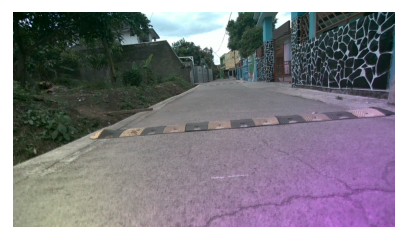

Processing 1 images
image                    shape: (720, 1280, 3)        min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max: 1280.00000  float64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32

*** No instances to display *** 



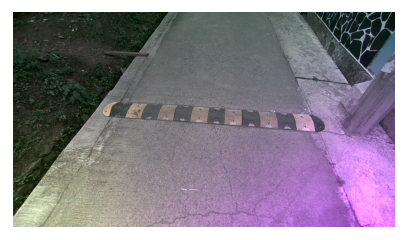

Processing 1 images
image                    shape: (720, 1280, 3)        min:    0.00000  max:  252.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -123.70000  max:  142.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max: 1280.00000  float64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32

*** No instances to display *** 



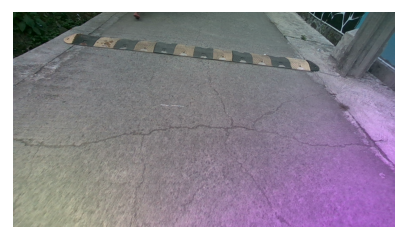

In [7]:

import skimage
real_test_dir = '/home/brin/Rahma/SpeedBumpDetection/test_images/'
image_paths = []
for filename in os.listdir(real_test_dir):
    if os.path.splitext(filename)[1].lower() in ['.png', '.jpg', '.jpeg']:
        image_paths.append(os.path.join(real_test_dir, filename))

for image_path in image_paths:
    img = skimage.io.imread(image_path)
    img_arr = np.array(img)
    results = model.detect([img_arr], verbose=1)
    r = results[0]
    visualize.display_instances(img, r['rois'], r['masks'], r['class_ids'], 
                                dataset_val.class_names, r['scores'], figsize=(5,5))

# Confusion Matrix on Validation Dataset


In [8]:
# old numpy version was  1.19.5.


config=inference_config
dataset = dataset_val


gt_tot = np.array([])
pred_tot = np.array([])

#mAP list
mAP_ = []

#compute gt_tot, pred_tot and mAP for each image in the test dataset
for image_id in dataset.image_ids:
    image, image_meta, gt_class_id, gt_bbox, gt_mask =\
        modellib.load_image_gt(dataset, config, image_id)#, #use_mini_mask=False)
    info = dataset.image_info[image_id]

    # Run the model
    results = model.detect([image], verbose=1)
    r = results[0]
    
    #compute gt_tot and pred_tot
    gt, pred = utils.gt_pred_lists(gt_class_id, gt_bbox, r['class_ids'], r['rois'])
    gt_tot = np.append(gt_tot, gt)
    pred_tot = np.append(pred_tot, pred)
    
    #precision_, recall_, AP_ 
    AP_, precision_, recall_, overlap_ = utils.compute_ap(gt_bbox, gt_class_id, gt_mask,
                                          r['rois'], r['class_ids'], r['scores'], r['masks'])
    #check if the vectors len are equal
    print("the actual len of the gt vect is : ", len(gt_tot))
    print("the actual len of the pred vect is : ", len(pred_tot))
    
    mAP_.append(AP_)
    print("Average precision of this image : ",AP_)
    print("The actual mean average precision for the whole images", sum(mAP_)/len(mAP_))
    #print("Ground truth object : "+dataset.class_names[gt])

    #print("Predicted object : "+dataset.class_names[pred])
    # for j in range(len(dataset.class_names[gt])):
	    # print("Ground truth object : "+j)


Processing 1 images
image                    shape: (512, 512, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
the actual len of the gt vect is :  1
the actual len of the pred vect is :  1
Average precision of this image :  0.0
The actual mean average precision for the whole images 0.0
Processing 1 images
image                    shape: (512, 512, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
the actual len of the gt

In [11]:
import pandas as pd
gt_tot=gt_tot.astype(int)
pred_tot=pred_tot.astype(int)
#save the vectors of gt and pred
save_dir = "output"
gt_pred_tot_json = {"gt_tot" : gt_tot, "pred_tot" : pred_tot}
df = pd.DataFrame(gt_pred_tot_json)
if not os.path.exists(save_dir):
    os.makedirs(save_dir)
df.to_json(os.path.join(save_dir,"gt_pred_test.json"))


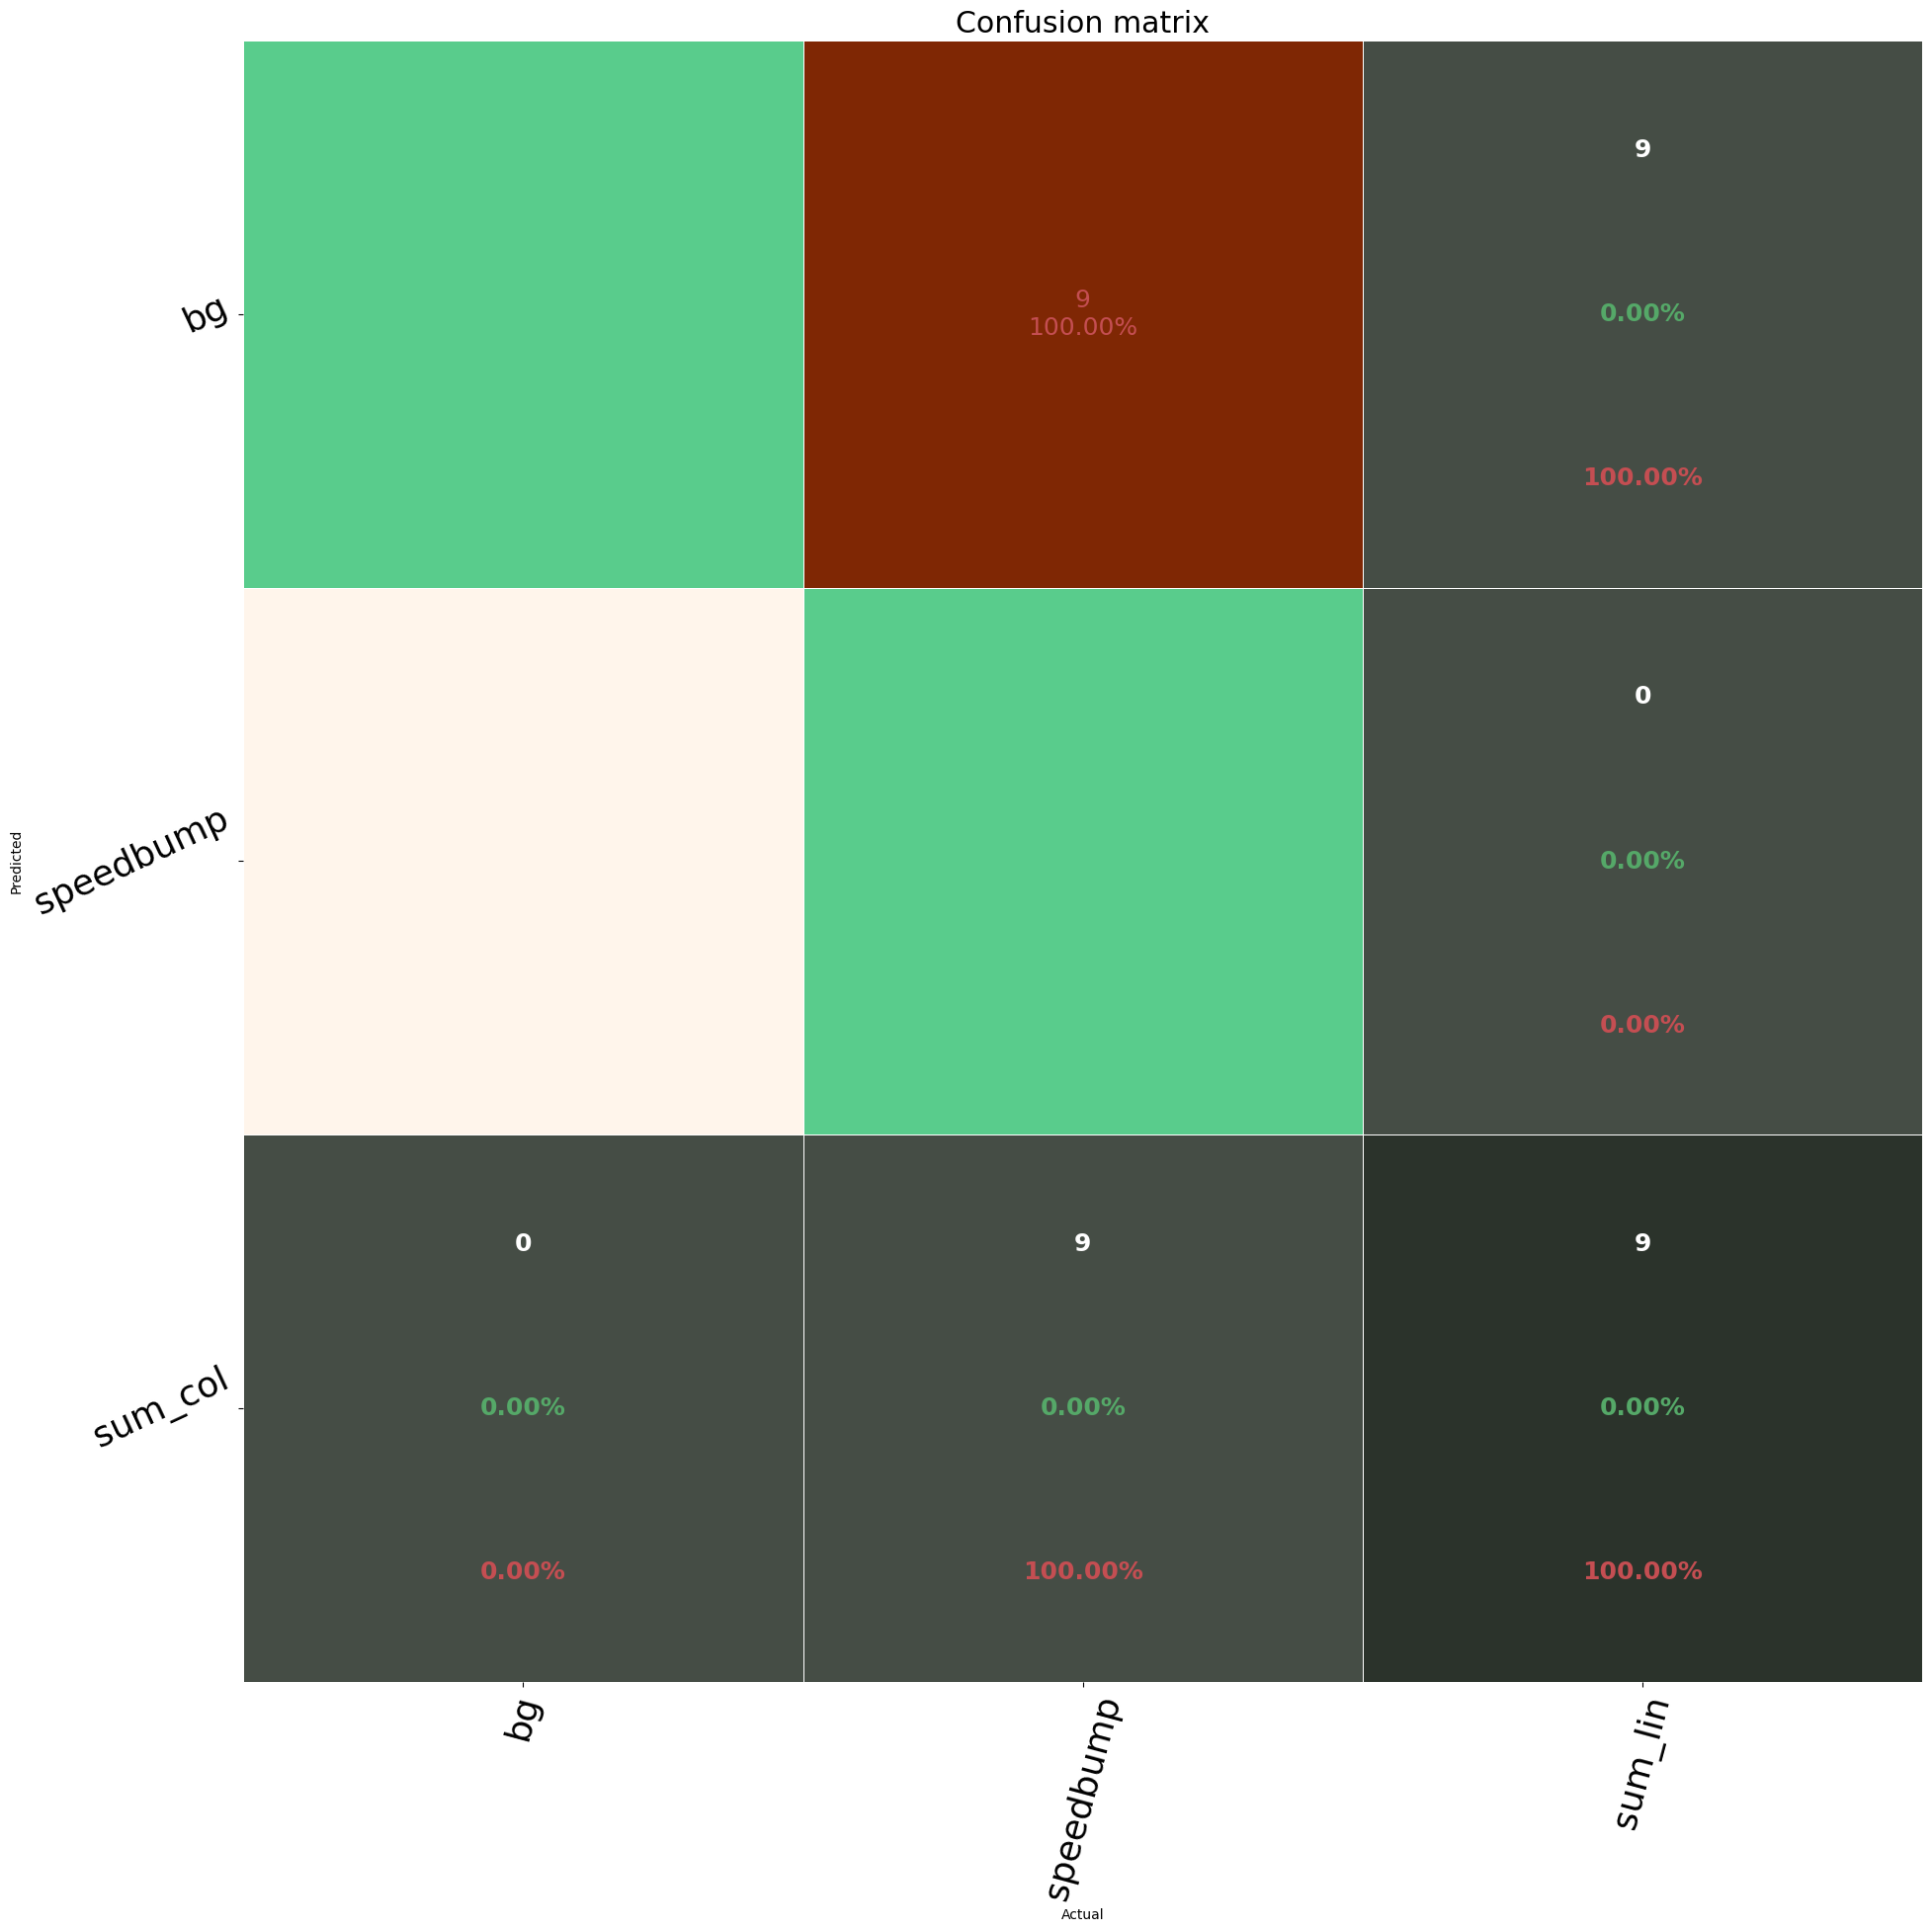

In [12]:
tp,fp,fn=utils.plot_confusion_matrix_from_data(gt_tot,pred_tot,columns=["bg","speedbump"] ,fz=18, figsize=(20,20), lw=0.5)

In [13]:
print("tp for each class :",tp)
print("fp for each class :",fp)
print("fn for each class :",fn)

#eliminate the background class from tps fns and fns lists since it doesn't concern us anymore : 
del tp[0]
del fp[0]
del fn[0]
print("\n########################\n")
print("tp for each class :",tp)
print("fp for each class :",fp)
print("fn for each class :",fn)

tp for each class : [0, 0]
fp for each class : [9, 0]
fn for each class : [0, 9]

########################

tp for each class : [0]
fp for each class : [0]
fn for each class : [9]


# # Draw precision-recall curve  

##### The PR curve is for single detected image 

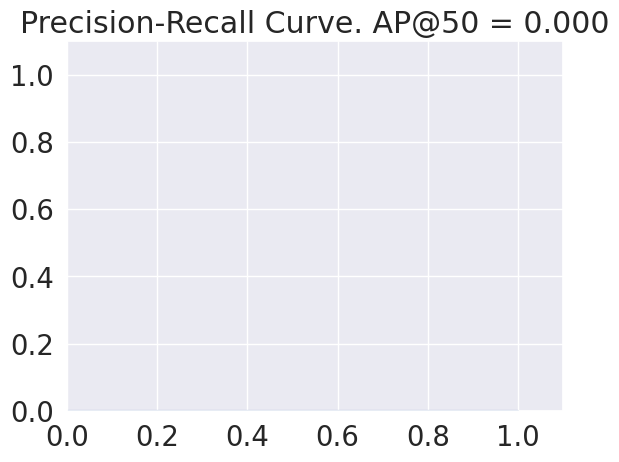

In [14]:
# Draw precision-recall curve

AP, precisions, recalls, overlaps = utils.compute_ap(gt_bbox, gt_class_id, gt_mask,
                                          r['rois'], r['class_ids'], r['scores'], r['masks'])
visualize.plot_precision_recall(AP, precisions, recalls)

# calculate the mAP for a batch of validation images

In [15]:
path = os.getcwd()
#model_tar = "nuclei_datasets.tar.gz"
data_path = os.path.join(path + '/dataset')
model_path = os.path.join(path + '/logs/object20230216T1912')
weights_path = os.path.join(model_path + '/mask_rcnn_object_0300.h5') #My weights file

DEVICE = "/gpu:0" 


config=inference_config
dataset = dataset_val


with tf.device(DEVICE):
    model = modellib.MaskRCNN(mode="inference", model_dir=model_path, config=config)

model.load_weights(weights_path, by_name=True)

    
def compute_batch_ap(image_ids):
    APs = []
    for image_id in image_ids:
        # Load image
        image, image_meta, gt_class_id, gt_bbox, gt_mask = modellib.load_image_gt(dataset, config, image_id)
        # Run object detection
        results = model.detect([image], verbose=0)
        # Compute AP
        r = results[0]
        AP, precisions, recalls, overlaps = utils.compute_ap(gt_bbox, gt_class_id, gt_mask, r['rois'], r['class_ids'], r['scores'], r['masks'])
        AP = 1 - AP
        APs.append(AP)
    return APs, precisions, recalls

#dataset.load_nucleus(data_path, 'val')
#dataset.prepare()
print("Images: {}\nClasses: {}".format(len(dataset.image_ids), dataset.class_names))
print("Loading weights ", weights_path)

image_ids = np.random.choice(dataset.image_ids, 25)
APs, precisions, recalls = compute_batch_ap(image_ids)
print("mAP @ IoU=50: ", APs)

AP = np.mean(APs)
visualize.plot_precision_recall(AP, precisions, recalls)
plt.show()
    
    
    

FileNotFoundError: [Errno 2] Unable to synchronously open file (unable to open file: name = '/home/brin/Rahma/SpeedBumpDetection/logs/object20230216T1912/mask_rcnn_object_0300.h5', errno = 2, error message = 'No such file or directory', flags = 0, o_flags = 0)

# Load a random image from the images folder and perform prediction

In [20]:

# IMAGE_DIR = os.path.join(ROOT_DIR, "test_images")

# # COCO Class names
# # Index of the class in the list is its ID. For example, to get ID of
# # the teddy bear class, use: class_names.index('teddy bear')
# class_names = ['BG', 'Hard_hat', 'Safety_vest']

# file_names = next(os.walk(IMAGE_DIR))[2]
# image = skimage.io.imread(os.path.join(IMAGE_DIR, random.choice(file_names)))

# # Run detection
# results = model.detect([image], verbose=1)

# # Visualize results
# r = results[0]
# visualize.display_instances(image, r['rois'], r['masks'], r['class_ids'], 
#                             class_names, r['scores'])